In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

from matplotlib import cm
from matplotlib.ticker import LinearLocator
from slicer_generation import *
from surface_solns import *

In [2]:
%matplotlib ipympl

checking col, slice: 0.0, 0.0
t is -0.5077999352216209
result is -0.4152053959089909
analytic soln: -0.9614803401237304
numerical soln:-0.9378757515030056


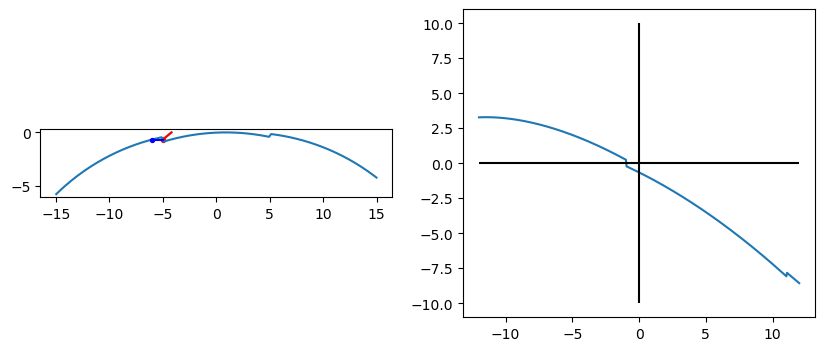

In [2]:
sag_func = tilted_plane_sag
surface_norm_func = tilted_plane_surface_normal
transfer_dist_func = tilted_plane_transfer
critical_xy_func = tilted_plane_critical_xy


sag_func = conic_3d_sag
surface_norm_func = conic_3d_surface_normal
transfer_dist_func = conic_3d_transfer
critical_xy_func = conic_3d_critical_xy


n_each = 1
n_rows = 1
n_cols = 3
mode = 1
trace_walls = True
active_x = False
active_y = False
dalpha = 0
dbeta = 10
dgamma = 5
alpha_cen = 0
beta_cen = 5
gamma_cen = 0
dx = 10
dy = 3
r = -20.1
c = 1/r
k = 0
xgap_width = 0
xgap_depth = -3
ygap_width = 0
ygap_depth = 2
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, trace_walls, active_x, active_y, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, xgap_width, xgap_depth, ygap_width, ygap_depth)

yt = 0
x = np.linspace(-20, 20, 200)
surf = np.zeros(len(x))
for i,x1 in enumerate(x):
    surf[i] = make_image_slicer(x1, yt, p, sag_func)


xt = -4.2
l = 1.2
m = 0
n = 0.8
l = l / np.sqrt(l*l+m*m+n*n)
m = m / np.sqrt(l*l+m*m+n*n)
n = n / np.sqrt(l*l+m*m+n*n)

xs, ys, zs, tsol, ln, mn, nn = ray_trace_slicer(xt, yt, l, m, n, p, sag_func, critical_xy_func, transfer_dist_func, surface_norm_func)
print("analytic soln: " + str(tsol))

t = np.linspace(-12, 12, 500)
feval = np.zeros(len(t))
for i,t1 in enumerate(t):
    feval[i] = transfer_equation(t1, xt, yt, l, m, n, p, sag_func)
idx = np.nanargmin(np.abs(feval))
tnum = t[idx]
print("numerical soln:" + str(tnum))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axs[0].plot(x, surf)

# Draw analytically calculated ray and surface normal
axs[0].plot([xt, xt + tsol*l], [0, tsol*n], c='r', zorder=1)
axs[0].scatter([xt + tsol*l], [tsol*n], c='r', s=8, zorder=1)
axs[0].plot([xs, xs+ln], [zs, zs+nn], c='b')
axs[0].scatter([xs+ln], [zs+nn], c='b', s=8, zorder=10)

#axs[0].plot([yt, yt + tsol*m], [0, tsol*n], c='r', zorder=1)
#axs[0].scatter([yt + tsol*m], [tsol*n], c='r', s=8, zorder=1)
#axs[0].plot([ys, ys+mn], [zs, zs+nn], c='b')
#axs[0].scatter([ys+mn], [zs+nn], c='b', s=8, zorder=10)

# Numerically determined ray
axs[0].plot([xt, xt + tnum*l], [0, tnum*n], c='gray', zorder=0)
axs[0].scatter([xt + tnum*l], [tnum*n], c='gray', s=8, zorder=0)
#print(tnum*n)

#axs[0].plot([yt, yt + tnum*m], [0, tnum*n], c='gray', zorder=0)
#axs[0].scatter([yt + tnum*m], [tnum*n], c='gray', s=8, zorder=0)

axs[0].set_aspect("equal")

axs[1].plot(t, feval)
axs[1].hlines(0, t[0], t[-1], colors='k')
axs[1].vlines(0, -10, 10, colors='k')
#axs[1].set_ylim(np.nanmin(feval), np.nanmax(feval))

plt.show()

checking col, slice: 1.0, 0.0
t is -7.900088711885607
result is 9.354582342655998
analytic soln: -6.628725367670625
numerical soln:-6.613226452905812


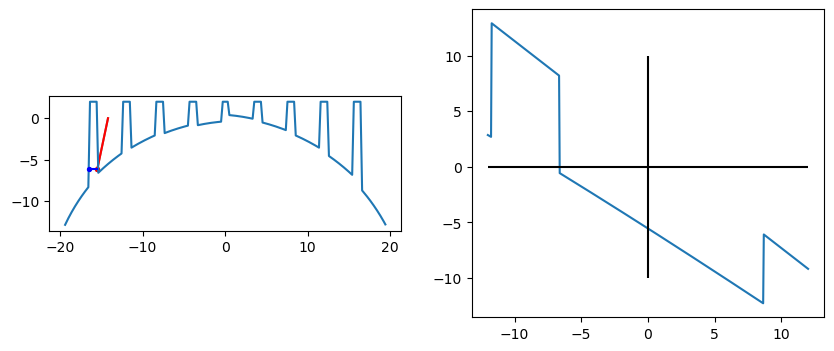

In [7]:
sag_func = tilted_plane_sag
surface_norm_func = tilted_plane_surface_normal
transfer_dist_func = tilted_plane_transfer
critical_xy_func = tilted_plane_critical_xy


sag_func = conic_3d_sag
surface_norm_func = conic_3d_surface_normal
transfer_dist_func = conic_3d_transfer
critical_xy_func = conic_3d_critical_xy


n_each = 5
n_rows = 2
n_cols = 3
mode = 1
trace_walls = True
active_x = False
active_y = False
dalpha = -15
dbeta = 15
dgamma = 10
alpha_cen = 0
beta_cen = 5
gamma_cen = -5
dx = 10
dy = 3
r = -25.1
c = 1/r
k = 0
xgap_width = 2
xgap_depth = 3
ygap_width = 1
ygap_depth = 2
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, trace_walls, active_x, active_y, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, xgap_width, xgap_depth, ygap_width, ygap_depth)

xt = 0
y = np.linspace(-20, 20, 200)
surf = np.zeros(len(y))
for i,y1 in enumerate(y):
    surf[i] = make_image_slicer(xt, y1, p, sag_func)


yt = -14.2
l = 0
m = 0.1
n = 0.5
l = l / np.sqrt(l*l+m*m+n*n)
m = m / np.sqrt(l*l+m*m+n*n)
n = n / np.sqrt(l*l+m*m+n*n)

xs, ys, zs, tsol, ln, mn, nn = ray_trace_slicer(xt, yt, l, m, n, p, sag_func, critical_xy_func, transfer_dist_func, surface_norm_func)
print("analytic soln: " + str(tsol))

t = np.linspace(-12, 12, 500)
feval = np.zeros(len(t))
for i,t1 in enumerate(t):
    feval[i] = transfer_equation(t1, xt, yt, l, m, n, p, sag_func)
idx = np.nanargmin(np.abs(feval))
tnum = t[idx]
print("numerical soln:" + str(tnum))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axs[0].plot(y, surf)

# Draw analytically calculated ray and surface normal
axs[0].plot([yt, yt + tsol*m], [0, tsol*n], c='r', zorder=1)
axs[0].scatter([yt + tsol*m], [tsol*n], c='r', s=8, zorder=1)
axs[0].plot([ys, ys+mn], [zs, zs+nn], c='b')
axs[0].scatter([ys+mn], [zs+nn], c='b', s=8, zorder=10)

#axs[0].plot([yt, yt + tsol*m], [0, tsol*n], c='r', zorder=1)
#axs[0].scatter([yt + tsol*m], [tsol*n], c='r', s=8, zorder=1)
#axs[0].plot([ys, ys+mn], [zs, zs+nn], c='b')
#axs[0].scatter([ys+mn], [zs+nn], c='b', s=8, zorder=10)

# Numerically determined ray
axs[0].plot([yt, yt + tnum*m], [0, tnum*n], c='gray', zorder=0)
axs[0].scatter([yt + tnum*m], [tnum*n], c='gray', s=8, zorder=0)
#print(tnum*n)

#axs[0].plot([yt, yt + tnum*m], [0, tnum*n], c='gray', zorder=0)
#axs[0].scatter([yt + tnum*m], [tnum*n], c='gray', s=8, zorder=0)

axs[0].set_aspect("equal")

axs[1].plot(t, feval)
axs[1].hlines(0, t[0], t[-1], colors='k')
axs[1].vlines(0, -10, 10, colors='k')
#axs[1].set_ylim(np.nanmin(feval), np.nanmax(feval))

plt.show()

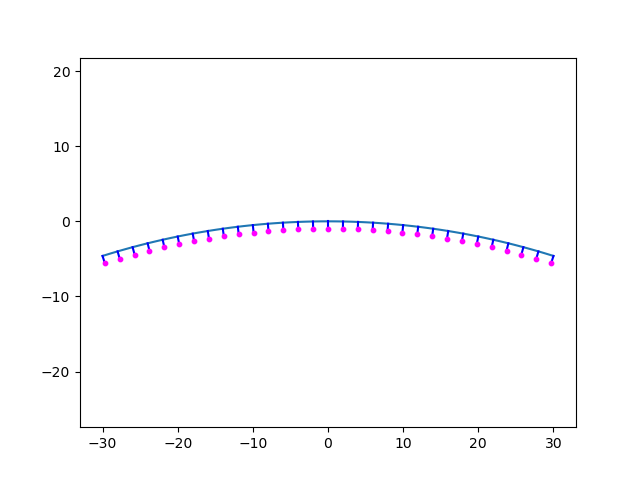

In [31]:
#sag_func = tilted_plane_sag
#surface_norm_func = tilted_plane_surface_normal
sag_func = conic_3d_sag
surface_norm_func = conic_3d_surface_normal

xs = np.linspace(-30,30,100)
y0 = 0
r = 100
c = -1/r
k = 0
alpha = 0
beta = 0
gamma = 0

surface = sag_func(xs, y0, c, k, alpha, beta, gamma)

#print(conic_3d_sag_critical_x_y(c, k, 0, 2, gamma))


#idx = np.argmin(surface)
#print(xs[idx])

plt.figure()
plt.plot(xs, surface)

for xtest in np.arange(-30, 30.1, 2):
    nx, ny, nz = surface_norm_func(xtest, y0, c, k, alpha, beta, gamma)
    ztest = sag_func(xtest, y0, c, k, alpha, beta, gamma)
    plt.plot([xtest, xtest+nx], [ztest, ztest+nz], c='b')
    plt.scatter([xtest+nx], [ztest+nz], c='fuchsia', s=10, zorder=10)
    #plt.plot([xtest, xtest-c*xtest], [ztest, ztest+1-c*ztest], c='r')
plt.plot()
plt.axis("equal")
#plt.plot([xtest, xtest-c*xtest], [ztest, ztest+1-c*ztest], c='r')
#plt.ylim(-1,4)
#plt.scatter(xs[idx], surface[idx], c='r')
plt.show()

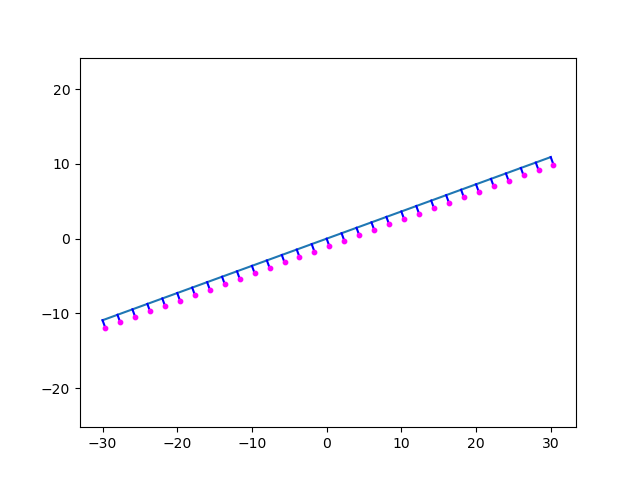

In [47]:
ys = np.linspace(-30,30,100)
x0 = 0

surface = sag_func(x0, ys, c, k, alpha, beta, gamma)

plt.figure()
plt.plot(ys, surface)

for ytest in np.arange(-30, 30.1, 2):
    nx, ny, nz = surface_norm_func(x0, ytest, c, k, alpha, beta, gamma)
    ztest = sag_func(x0, ytest, c, k, alpha, beta, gamma)
    plt.plot([ytest, ytest+ny], [ztest, ztest+nz], c='b')
    plt.scatter([ytest+ny], [ztest+nz], c='fuchsia', s=10, zorder=10)
    #plt.plot([ytest, ytest-c*ytest], [ztest, ztest+1-c*ztest], c='r'
plt.axis("equal")
plt.show()

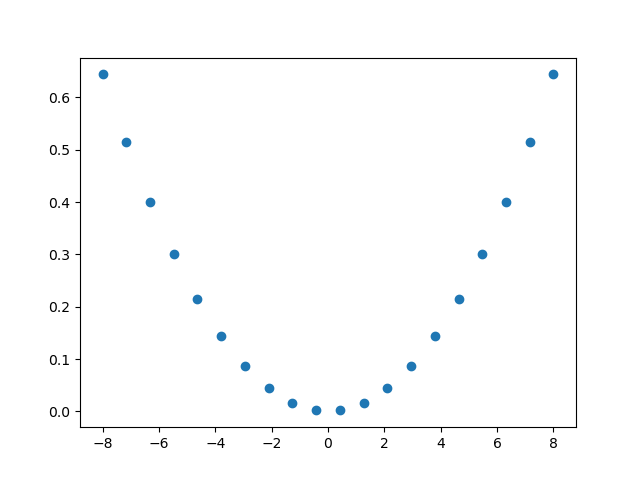

In [7]:
n_each = 1
n_rows = 1
n_cols = 1
mode = 0
dalpha = -20
dbeta = 0
dgamma = 10
alpha_cen = 0
beta_cen = 0
gamma_cen = 0
dx = 15
dy = 5
r = 50
c = 1/r
k = -1
gx_width = 0
gx_depth = np.nan
gy_width = 0
gy_depth = np.nan
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, False, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, gx_width, gx_depth, gy_width, gy_depth)

N = 20
r = 20
k = 0
t = -10

y = np.linspace(-8, 8, N)
x = np.linspace(-8, 8, N)
z = conic_3d_sag(x, 0, c, k, 0, 0, 0)

plt.figure()
plt.scatter(x, z)
plt.show()

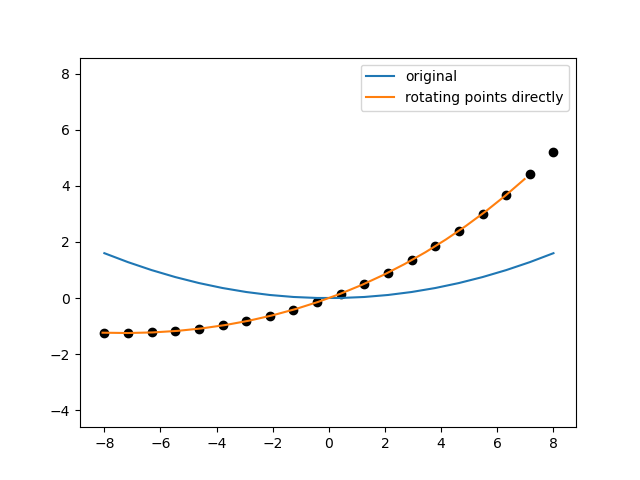

In [9]:
N = 20
r = 20
k = -1
t = 20

# perform the rotation manually with a rotation matrix
x1 = np.linspace(-8, 8, N)
y1 = []
x2 = []
y2 = []
#y3 = []
trad = -t*np.pi/180

for i in range(N):
    y1.append(conic(x1[i],r,k))
    xnew = x1[i]*np.cos(trad)+y1[i]*np.sin(trad)
    ynew = -x1[i]*np.sin(trad)+y1[i]*np.cos(trad)
    x2.append(xnew)
    y2.append(ynew)
    #y3.append(rotated_conic(x1[i], r, k, t))

y3 = conic_3d_sag(x1, 0, 1/r, k, 0, 0, t)
plt.figure()
plt.plot(x1,y1,label='original')
plt.plot(x2,y2,label='rotating points directly')
plt.scatter(x1,y3,c='k')
#plt.vlines([-2,0,2], -1, 1)
#plt.ylim(0,8)
#plt.xlim(-8,8)
plt.axis('equal')
plt.legend()
#plt.savefig("rotated_conics.png",dpi=300,facecolor="white")
plt.show()

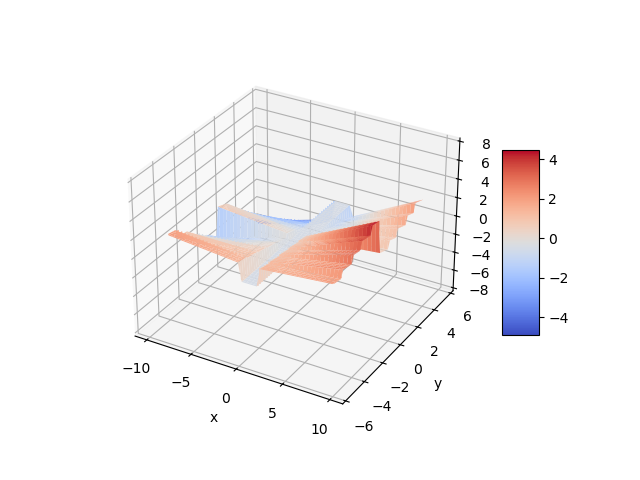

In [4]:
sag_func = tilted_plane_sag#conic_3d_sag

n_each = 5
n_rows = 2
n_cols = 2
mode = 1
trace_gaps = False
active_x = False
active_y = False
dalpha = 10
dbeta = 10
dgamma = 5
alpha_cen = 20
beta_cen = 10
gamma_cen = 0
dx = 8
dy = 1
r = 50
c = 1/r
k = 0
xgap_width = 2
xgap_depth = -0.5
ygap_width = 0
ygap_depth = -0.8
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, trace_gaps, active_x, active_y, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, xgap_width, xgap_depth, ygap_width, ygap_depth)
xsize, ysize = get_slicer_size(p)

N = 200

#Nx = n_cols * 8
#Ny = n_rows * n_each * 8
x = np.linspace(-1.1*xsize/2,1.1*xsize/2,N)
y = np.linspace(-1.1*ysize/2,1.1*ysize/2,N)

Z = np.zeros((N,N))
for i,x1 in enumerate(x):
    for j,y1 in enumerate(y):
        Z[j,i]=make_image_slicer(x1, y1, p, sag_func)
        #Z[i,j]=make_image_slicer2(x1, y1, n_each, dalpha, dbeta, alpha_cen, beta_cen, dx, dy, rx, ry, kx, ky)
    

X, Y = np.meshgrid(x, y)
#Z2 = make_slice(X, Y, rx, ry, kx, ky, 0, 0)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
#ax.scatter(9.487179487179485,-4.364548494983277,-0.6999614810235664, c='g')
#ax.scatter(9.487179487179485,14.899665551839465,3.8157755724491054, c='g')
#surf = ax.plot_surface(X, Y, Z2, cmap=cm.viridis)
#ax.zaxis.set_major_formatter('{x:.02f}')
#ax.view_init(azim=90, elev=0)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlim(-8, 8)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [46]:
def rotatebackward3d(x, y, z, alpha,beta):
    alpha = convert_angle(alpha) * np.pi/180
    beta = convert_angle(beta) * np.pi/180
    cosa = np.cos(alpha)
    cosa2 = cosa*cosa
    sina = np.sin(alpha)
    sina2 = sina*sina
    cosb = np.cos(beta)
    cosb2 = cosb*cosb
    sinb = np.sin(beta)
    sinb2 = sinb*sinb
    
    # Inverse transformation matrix for a 3D rotation about the global x- and y-axes
    det = cosa2*cosb2 + cosb2*sina2 + cosa2*sinb2 + sina2*sinb2
    a = (cosa2*cosb + cosb*sina2) / det
    b = sina*sinb / det
    c = -1*cosa*sinb / det
    d = (cosa*cosb2 + cosa*sinb2) / det
    f = (cosb2*sina + sina*sinb2) / det
    g = (cosa2*sinb + sina2*sinb) / det
    h = -1*cosb*sina / det
    m = cosa*cosb / det
    xp = a*x + b*y + c*z
    yp = d*y + f*z
    zp = g*x + h*y + m*z
    #print([[a,b,c],[0,d,f],[g,h,m]])
    xp = a*x + b*y + c*z
    yp = d*y + f*z
    zp = g*x + h*y + m*z
    return xp, yp, zp

def rotateforward3d(x,y,z,alpha,beta):
    alpha = convert_angle(alpha) * np.pi/180
    beta = convert_angle(beta) * np.pi/180
    cosa = np.cos(alpha)
    cosa2 = cosa*cosa
    sina = np.sin(alpha)
    sina2 = sina*sina
    cosb = np.cos(beta)
    cosb2 = cosb*cosb
    sinb = np.sin(beta)
    sinb2 = sinb*sinb
    
    xp = x*cosb + y*sinb
    yp = x*sina*sinb + y*cosa - z*cosb*sina
    zp = -x*cosa*sinb + y*sina + z*cosa*cosb
    return xp, yp, zp


alpha=10
beta=20

N = 30
x = np.linspace(-10,10,N)
y = np.linspace(-10,10,N)

xold = []
yold = []
zold = []
xnew = []
ynew = []
znew = []

Z = np.zeros((N,N))

for i,x1 in enumerate(x):
    for j,y1 in enumerate(y):
        z1 = rotated_conic_3d(x1,y1,20,20,0,0,0,0)
        Z[i,j] = z1
        x1po, y1po, z1po = rotateforward3d(x1,y1,z1,alpha,beta)
        x1p, y1p, z1p = rotatebackward3d(x1po, y1po, z1po, alpha, beta)
        xold.append(x1po)
        yold.append(y1po)
        zold.append(z1po)
        xnew.append(x1p)
        ynew.append(y1p)
        znew.append(z1p)
    
X, Y = np.meshgrid(x, y)
#Z2 = make_slice(X, Y, rx, ry, kx, ky, 0, 0)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
ax.scatter(xold,yold,zold)
#ax.scatter(xnew,ynew,znew)
#surf = ax.plot_surface(X, Y, Z2, cmap=cm.viridis)
#ax.zaxis.set_major_formatter('{x:.02f}')
#ax.view_init(azim=90, elev=0)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlim(0, 8)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

NameError: name 'rotated_conic_3d' is not defined